## Classificação de Imagem - Homem ou Cavalo?

In [1]:
# Importando bibliotecas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

In [18]:
import os, glob

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [3]:
# Diretorio com as imagens de cavalos para treinamento

train_horse_dir = os.path.join('C:\minicurso_ia\Dataset\Dataset\horses')

In [4]:
# Diretorio com as imagens de humanos para treinamento

train_human_dir = os.path.join('C:\minicurso_ia\Dataset\Dataset\humans')

In [5]:
print('Total de imagens de cavalo para treinamento: ', len(os.listdir(train_horse_dir)))

Total de imagens de cavalo para treinamento:  500


In [6]:
print('Total de imagens de humanos para treinamento: ', len(os.listdir(train_human_dir)))

Total de imagens de humanos para treinamento:  527


## Construindo um modelo simples

* Primeiro passo: fazer a definição do modelo (fazer as camadas convulocionais) e achatamos o resultado final para alimentar 
as camadas densamente conectadas. Por fim, adicionamos as camadas densas

In [7]:
model = tf.keras.models.Sequential([
    #Formato do input é de 300x300 com 3 bytes de cor
    #Primeira convolução
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Segunda convolução
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Terceira convolução
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Quarta convolução
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Quinta convolução
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Achatar o resultado em uma DNN (Deep Natural Netwok - processar dados e reconhecer objetos visualmente)
    tf.keras.layers.Flatten(),
    # 512 neurons de camada oculta
    tf.keras.layers.Dense(512, activation='relu'),
    # 1 neuron de output. Tem um valor de 0-1 onde 0 é para cavalo e 1 para humano (já que temos somente duas classes)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
# Tirando um print da nossa rede neural
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

* A coluna 'out shape' mostra o tamanho do seu mapa de feições evolui em cada camada sucessiva. 
* As camadas de convolução reduzem um pouco o tamanho dos mapas de feições devido ao preenchimento e cada camada de agrupamento divide as dimensões pela metade.

## Configurando as especificações para o treinamento do modelo

* Vamos treinar nosso modelo com a perda **binary_crossentropy**, porque é um problema de classificação binária e nossa função de ativação final é um sigmóide
* Vamos usar o otimizador **rmsprop** com uma taxa de aprendizado de **0,001**. Durante o treinamento, vamos monitorar a precisão da classificação

In [9]:
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(learning_rate=0.001),
             metrics=['accuracy'])

## Pré-processamento de dados

* Vamos configurar geradores de dados que lerão imagens em nossas pastas de origem, convertê-los em tensores **float-32** e alimentá-los (com seus rótulos) para nossa rede. Teremos um gerador para as imagens de treinamento e outro para as imagens de validação. Nossos geradores produzirão lotes de imagens de tamanho 300x300 e seus rótulos(binários)

* Os dados que vão para as redes neurais geralmente devem ser normalizados de alguma forma para torná-los mais receptivos ao processamento pela rede (é incomum alimentar pixels brutos em um convnet). Em nosso caso, iremos pré-processar nossas imagens normalizando os valores de pixel para que fiquem na faixa de [0, 1]. Originalmente, todos os valores estão na faixa de [0, 255] intervalo.

* No Keras, isso pode ser feito por meio da classe **keras.preprocessing.image.ImageDataGenerator** usando parâmetros **rescale**. Essa classe **ImageDataGenerator** permite que você instancie geradores de lotes de imagens aumentadas(e seus rótulos) via **.flow(dados, rótulos)** ou **.flow_from_directory(diretório)**. Esses geradores podem então ser usados com os métodos do modelo Keras que aceitam geradores de dados como entradas: **fit_generator, avalia_generator** e **predict_generator**.

In [14]:
# Mudas a escala de todas as imagens para 1/255

train_datagen = ImageDataGenerator(rescale=1/255)

# Imagens de treinamento de fluxo em lotes de 128 usando o train_datagen generator
train_generator = train_datagen.flow_from_directory(
    'C:\minicurso_ia\Dataset\Dataset', # Diretório de imagens de treinamento
    target_size = (300, 300), # Todas as imagens em 300 x 300
    batch_size = 128,
    # estamos usando o binary_crossentropy loss, então precisamos de rótulos binários
    class_mode='binary')

Found 1027 images belonging to 2 classes.


## Fazendo o treinamento

Vamos treinar por 15 épocas - isso pode levar alguns minutos para ser executado

* A loss e a Accuracy são uma ótima indicação do progresso do treinamento. É fazer um palpite quanto à classificação dos dados de treinamento e, em seguida medi-los em relação ao rótulo conhecido, calculando o resultado. A precisão é a fração/porcentagem de previsões corretas

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=2)

model.save('horses_human_model.h5')

C:\Users\amand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
8/8 - 78s - loss: 0.8979 - accuracy: 0.5651
Epoch 2/15
8/8 - 35s - loss: 1.1700 - accuracy: 0.6752
Epoch 3/15
8/8 - 37s - loss: 0.4533 - accuracy: 0.8042
Epoch 4/15
8/8 - 38s - loss: 0.4863 - accuracy: 0.7976
Epoch 5/15
8/8 - 38s - loss: 0.4046 - accuracy: 0.8543
Epoch 6/15
8/8 - 37s - loss: 0.3228 - accuracy: 0.8966
Epoch 7/15
8/8 - 37s - loss: 0.4396 - accuracy: 0.8087
Epoch 8/15
8/8 - 37s - loss: 0.2331 - accuracy: 0.9077
Epoch 9/15
8/8 - 37s - loss: 0.1663 - accuracy: 0.9388
Epoch 10/15
8/8 - 38s - loss: 0.7019 - accuracy: 0.8743
Epoch 11/15
8/8 - 37s - loss: 0.1011 - accuracy: 0.9622
Epoch 12/15
8/8 - 37s - loss: 0.0616 - accuracy: 0.9722
Epoch 13/15
8/8 - 37s - loss: 0.0556 - accuracy: 0.9811
Epoch 14/15
8/8 - 36s - loss: 0.1989 - accuracy: 0.9388
Epoch 15/15
8/8 - 36s - loss: 0.0347 - accuracy: 0.9922


## Mostrar como a precisão evolui ao longo dos períodos de treinamento

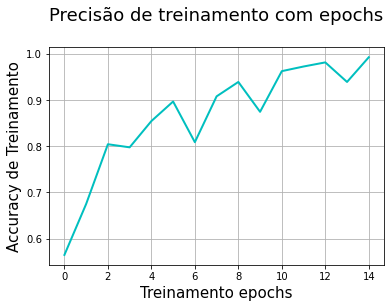

In [16]:
plt.plot(history.history['accuracy'], c='c', lw=2)
plt.grid(True)
plt.title('Precisão de treinamento com epochs\n', fontsize=18)
plt.xlabel('Treinamento epochs', fontsize=15)
plt.ylabel('Accuracy de Treinamento', fontsize=15)
plt.show()

## Fazendo a predição do modelo

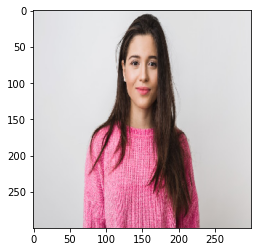

1.jpgshows a human image


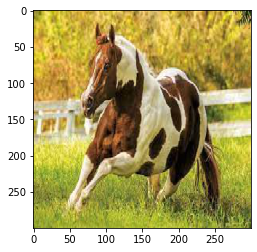

10.jpgshows a horse image


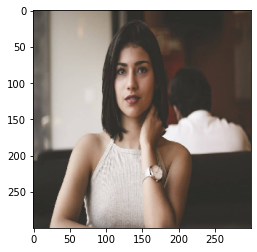

2.jpegshows a horse image


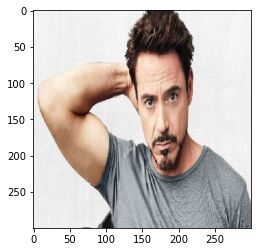

3.jpgshows a horse image


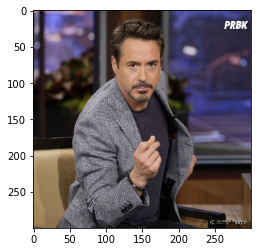

4.jpgshows a horse image


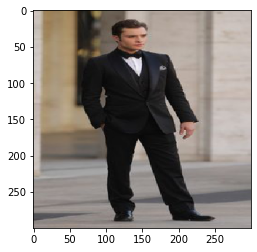

5.jpgshows a human image


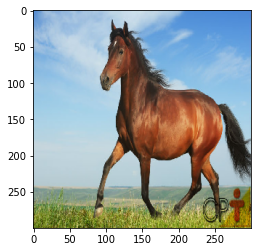

6.jpgshows a horse image


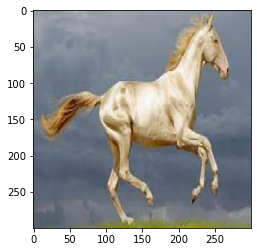

7.jpgshows a horse image


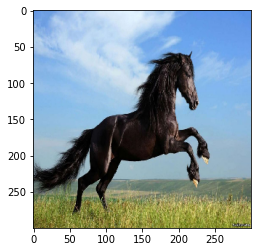

8.jpgshows a horse image


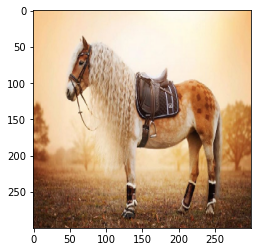

9.pngshows a horse image


In [28]:
import numpy as np
from keras.preprocessing import image

path_img = 'C:\minicurso_ia\Teste\Teste'

for arquivo in glob.glob(os.path.join(path_img, '*')):
    img = image.load_img(arquivo, target_size=(300, 300))
    plt.imshow(img)
    plt.show()
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    classes = model.predict(images, batch_size=10)
    
    if classes[0]>0.5:
        print(arquivo.split("\\")[-1] + 'shows a human image')
    else:
        print(arquivo.split("\\")[-1] + 'shows a horse image')